In [ ]:
import gspread
from oauth2client.service_account import ServiceAccountCredentials
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
# Helper functions for data processing
def extract_base(model_name):
    if 'Llama-2-7B' in model_name:
        return 'Llama-2-7B'
    elif 'Llama-3.1-8B' in model_name:
        return 'Llama-3.1-8B'
    elif 'Viking-7B' in model_name:
        return 'Viking-7B'
    else:
        return 'Other'
    
def extract_data_combination(model_name):
    if 'Bilingual-Code' in model_name:
        return 'Bilingual-Code'
    elif 'Bilingual' in model_name:
        return 'Bilingual'
    elif 'Monolingual-Code' in model_name:
        return 'Monolingual-Code'
    elif 'Monolingual' in model_name:
        return 'Monolingual'
    else:
        return 'Unknown'

In [3]:
# Connect to Google Sheets and get data
credentials = ServiceAccountCredentials.from_json_keyfile_name(
    "../../gckey.json",
    [
        "https://spreadsheets.google.com/feeds",
        "https://www.googleapis.com/auth/drive",
    ],
)
client = gspread.authorize(credentials)
spreadsheet = client.open("MaLA data mixing ablation")

# Get data from all three worksheets
Altruistic_SIB = spreadsheet.worksheet("Altruistic-SIB-200")
Selfish_SIB = spreadsheet.worksheet("Selfish-SIB-200")
Stagnant_SIB = spreadsheet.worksheet("Stagnant-SIB-200")

Altruistic_SIB_Data = Altruistic_SIB.get_all_records(value_render_option="UNFORMATTED_VALUE")
Selfish_SIB_Data = Selfish_SIB.get_all_records(value_render_option="UNFORMATTED_VALUE")
Stagnant_SIB_Data = Stagnant_SIB.get_all_records(value_render_option="UNFORMATTED_VALUE")

# Define languages and resource levels for each category
altruistic_languages = ['zho_Hans', 'ceb_Latn', 'mar_Deva', 'zul_Latn', 'khm_Khmr']
altruistic_resource_map = {
    'zho_Hans': 'High',
    'ceb_Latn': 'Mid',
    'mar_Deva': 'Mid',
    'zul_Latn': 'Low',
    'khm_Khmr': 'Low'
}

selfish_languages = ['deu_Latn', 'bel_Cyrl', 'mri_Latn', 'kir_Cyrl', 'nya_Latn']
selfish_resource_map = {
    'deu_Latn': 'High',
    'bel_Cyrl': 'Mid',
    'mri_Latn': 'Mid',
    'kir_Cyrl': 'Low',
    'nya_Latn': 'Low'
}

stagnant_languages = ['tha_Thai', 'yor_Latn', 'sna_Latn', 'wol_Latn']
stagnant_resource_map = {
    'tha_Thai': 'Mid',
    'yor_Latn': 'Mid',
    'sna_Latn': 'Low',
    'wol_Latn': 'Low'
}

# Process Altruistic data
df_Altruistic_SIB = pd.DataFrame(Altruistic_SIB_Data, columns=Altruistic_SIB_Data[0])
df_selected_altruistic = df_Altruistic_SIB[['Model'] + altruistic_languages]
df_long_altruistic = df_selected_altruistic.melt(id_vars='Model', var_name='Language', value_name='Score')
df_long_altruistic['Resource_Level'] = df_long_altruistic['Language'].map(altruistic_resource_map)
df_long_altruistic['Language_Type'] = 'Altruistic'

# Process Selfish data
df_Selfish_SIB = pd.DataFrame(Selfish_SIB_Data, columns=Selfish_SIB_Data[0])
df_selected_selfish = df_Selfish_SIB[['Model'] + selfish_languages]
df_long_selfish = df_selected_selfish.melt(id_vars='Model', var_name='Language', value_name='Score')
df_long_selfish['Resource_Level'] = df_long_selfish['Language'].map(selfish_resource_map)
df_long_selfish['Language_Type'] = 'Selfish'

# Process Stagnant data
df_Stagnant_SIB = pd.DataFrame(Stagnant_SIB_Data, columns=Stagnant_SIB_Data[0])
df_selected_stagnant = df_Stagnant_SIB[['Model'] + stagnant_languages]
df_long_stagnant = df_selected_stagnant.melt(id_vars='Model', var_name='Language', value_name='Score')
df_long_stagnant['Resource_Level'] = df_long_stagnant['Language'].map(stagnant_resource_map)
df_long_stagnant['Language_Type'] = 'Stagnant'

# Combine all data
df_combined = pd.concat([df_long_altruistic, df_long_selfish, df_long_stagnant])

# Extract model information
df_combined['Base_Model'] = df_combined['Model'].apply(extract_base)
df_combined['Data_Combination'] = df_combined['Model'].apply(extract_data_combination)

# Define category orders
data_combination_order = ['Bilingual', 'Bilingual-Code', 'Monolingual', 'Monolingual-Code']
resource_order = ['High', 'Mid', 'Low']
language_type_order = ['Altruistic', 'Selfish', 'Stagnant']
base_model_order = ['Llama-3.1-8B', 'Llama-2-7B', 'Viking-7B']

# Convert categories to ordered categorical data
df_combined['Data_Combination'] = pd.Categorical(df_combined['Data_Combination'], categories=data_combination_order, ordered=True)
df_combined['Resource_Level'] = pd.Categorical(df_combined['Resource_Level'], categories=resource_order, ordered=True)
df_combined['Language_Type'] = pd.Categorical(df_combined['Language_Type'], categories=language_type_order, ordered=True)
df_combined['Base_Model'] = pd.Categorical(df_combined['Base_Model'], categories=base_model_order, ordered=True)

# Filter to include only the specified base models
df_filtered = df_combined[df_combined['Base_Model'].isin(base_model_order)]

In [4]:
# Set the style for the plots
sns.set_theme(style="whitegrid")
plt.rcParams.update({
    'font.size': 14,
    'font.weight': 'bold',
    'axes.labelweight': 'bold',
    'axes.titleweight': 'bold',
    'legend.fontsize': 12,
    'legend.title_fontsize': 14
})

# Base lines for each model and resource level
base_lines = {
    # High resource languages
    ("Llama-3.1-8B", "High", "Altruistic"): 0.7549,
    ("Llama-2-7B", "High", "Altruistic"): 0.3382,
    ("Viking-7B", "High", "Altruistic"): 0.3725,
    ("Llama-3.1-8B", "High", "Selfish"): 0.7598,
    ("Llama-2-7B", "High", "Selfish"): 0.3922,
    ("Viking-7B", "High", "Selfish"): 0.3480,
    
    # Mid resource languages
    ("Llama-3.1-8B", "Mid", "Altruistic"): 0.6790,
    ("Llama-2-7B", "Mid", "Altruistic"): 0.2182,
    ("Viking-7B", "Mid", "Altruistic"): 0.2010,
    ("Llama-3.1-8B", "Mid", "Selfish"): 0.6618,
    ("Llama-2-7B", "Mid", "Selfish"): 0.2035,
    ("Viking-7B", "Mid", "Selfish"): 0.2255,
    ("Llama-3.1-8B", "Mid", "Stagnant"): 0.6348,
    ("Llama-2-7B", "Mid", "Stagnant"): 0.1961,
    ("Viking-7B", "Mid", "Stagnant"): 0.2917,
    
    # Low resource languages
    ("Llama-3.1-8B", "Low", "Altruistic"): 0.5932,
    ("Llama-2-7B", "Low", "Altruistic"): 0.1667,
    ("Viking-7B", "Low", "Altruistic"): 0.1496,
    ("Llama-3.1-8B", "Low", "Selfish"): 0.6348,
    ("Llama-2-7B", "Low", "Selfish"): 0.1765,
    ("Viking-7B", "Low", "Selfish"): 0.1863,
    ("Llama-3.1-8B", "Low", "Stagnant"): 0.4780,
    ("Llama-2-7B", "Low", "Stagnant"): 0.1790,
    ("Viking-7B", "Low", "Stagnant"): 0.1912,
}

# Aggregate data by language type, base model, data combination, and resource level
df_agg = df_filtered.groupby(['Language_Type', 'Base_Model', 'Data_Combination', 'Resource_Level'], as_index=False)['Score'].mean()

/tmp/ipykernel_1347791/590199947.py:46: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  df_agg = df_filtered.groupby(['Language_Type', 'Base_Model', 'Data_Combination', 'Resource_Level'], as_index=False)['Score'].mean()


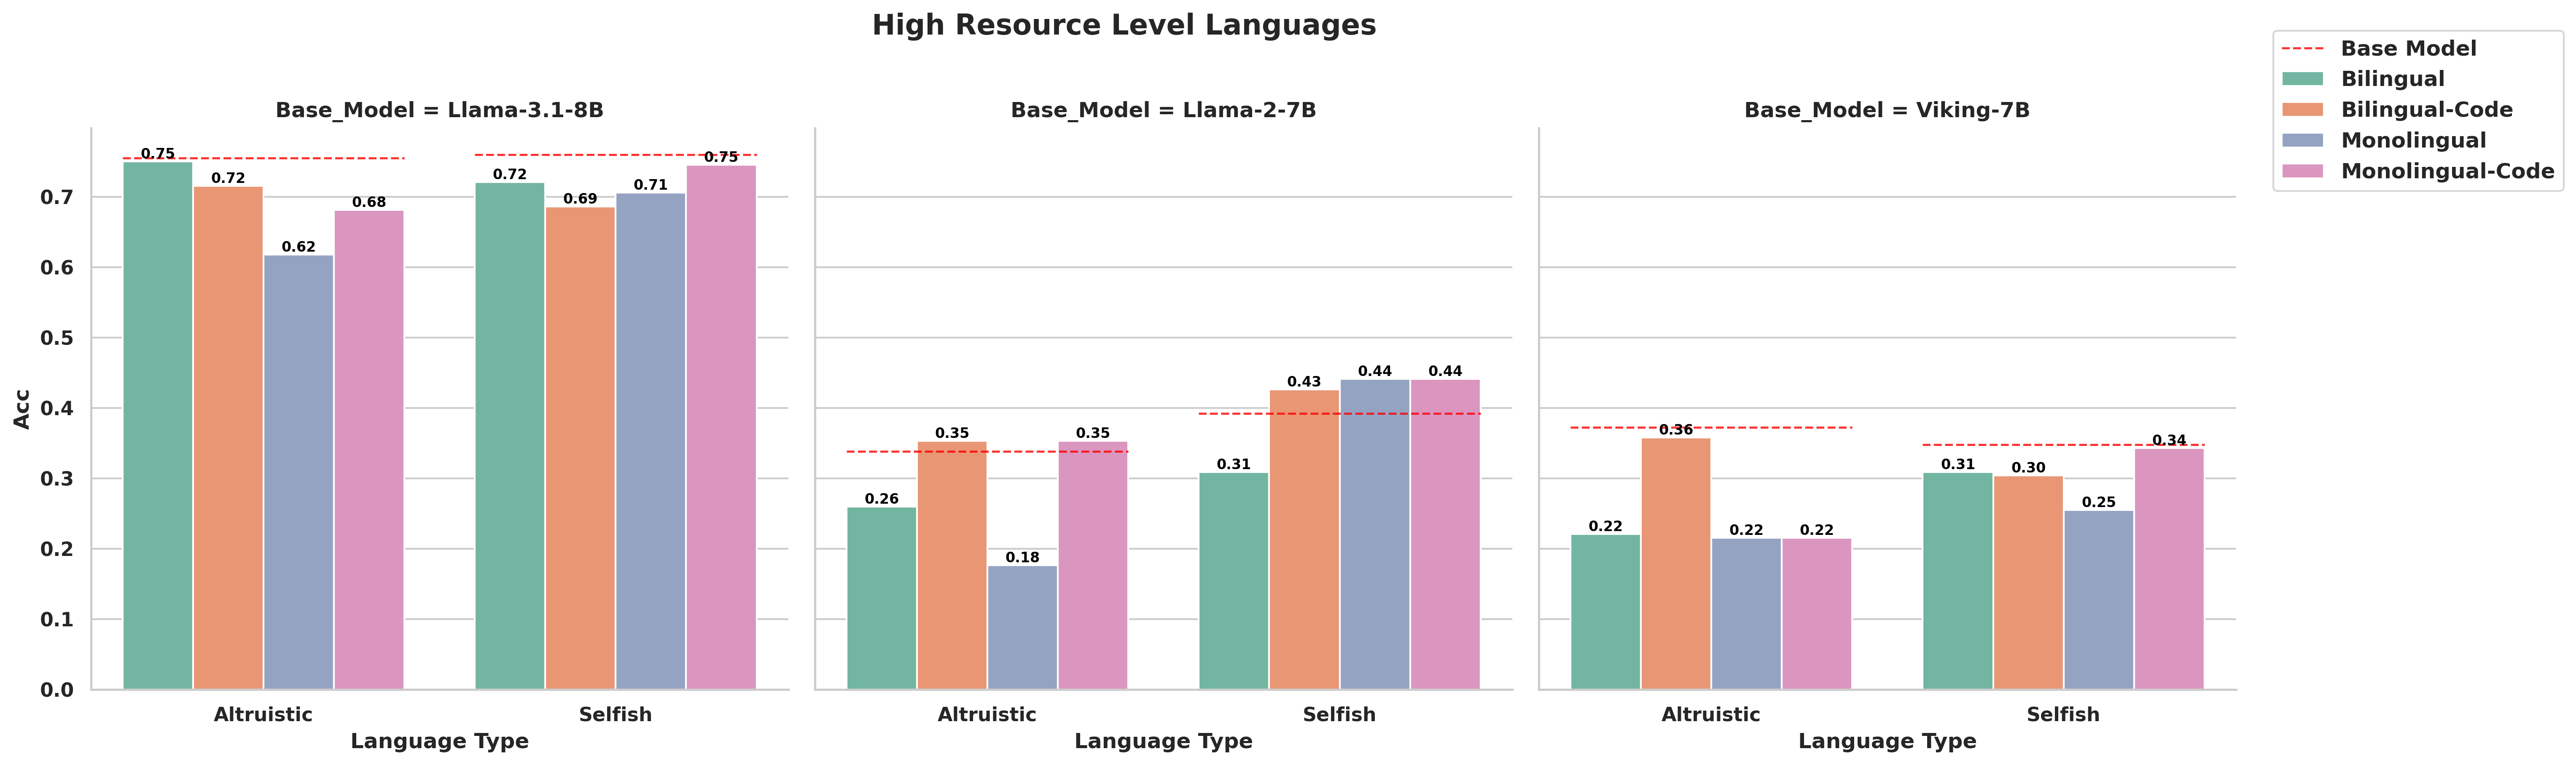

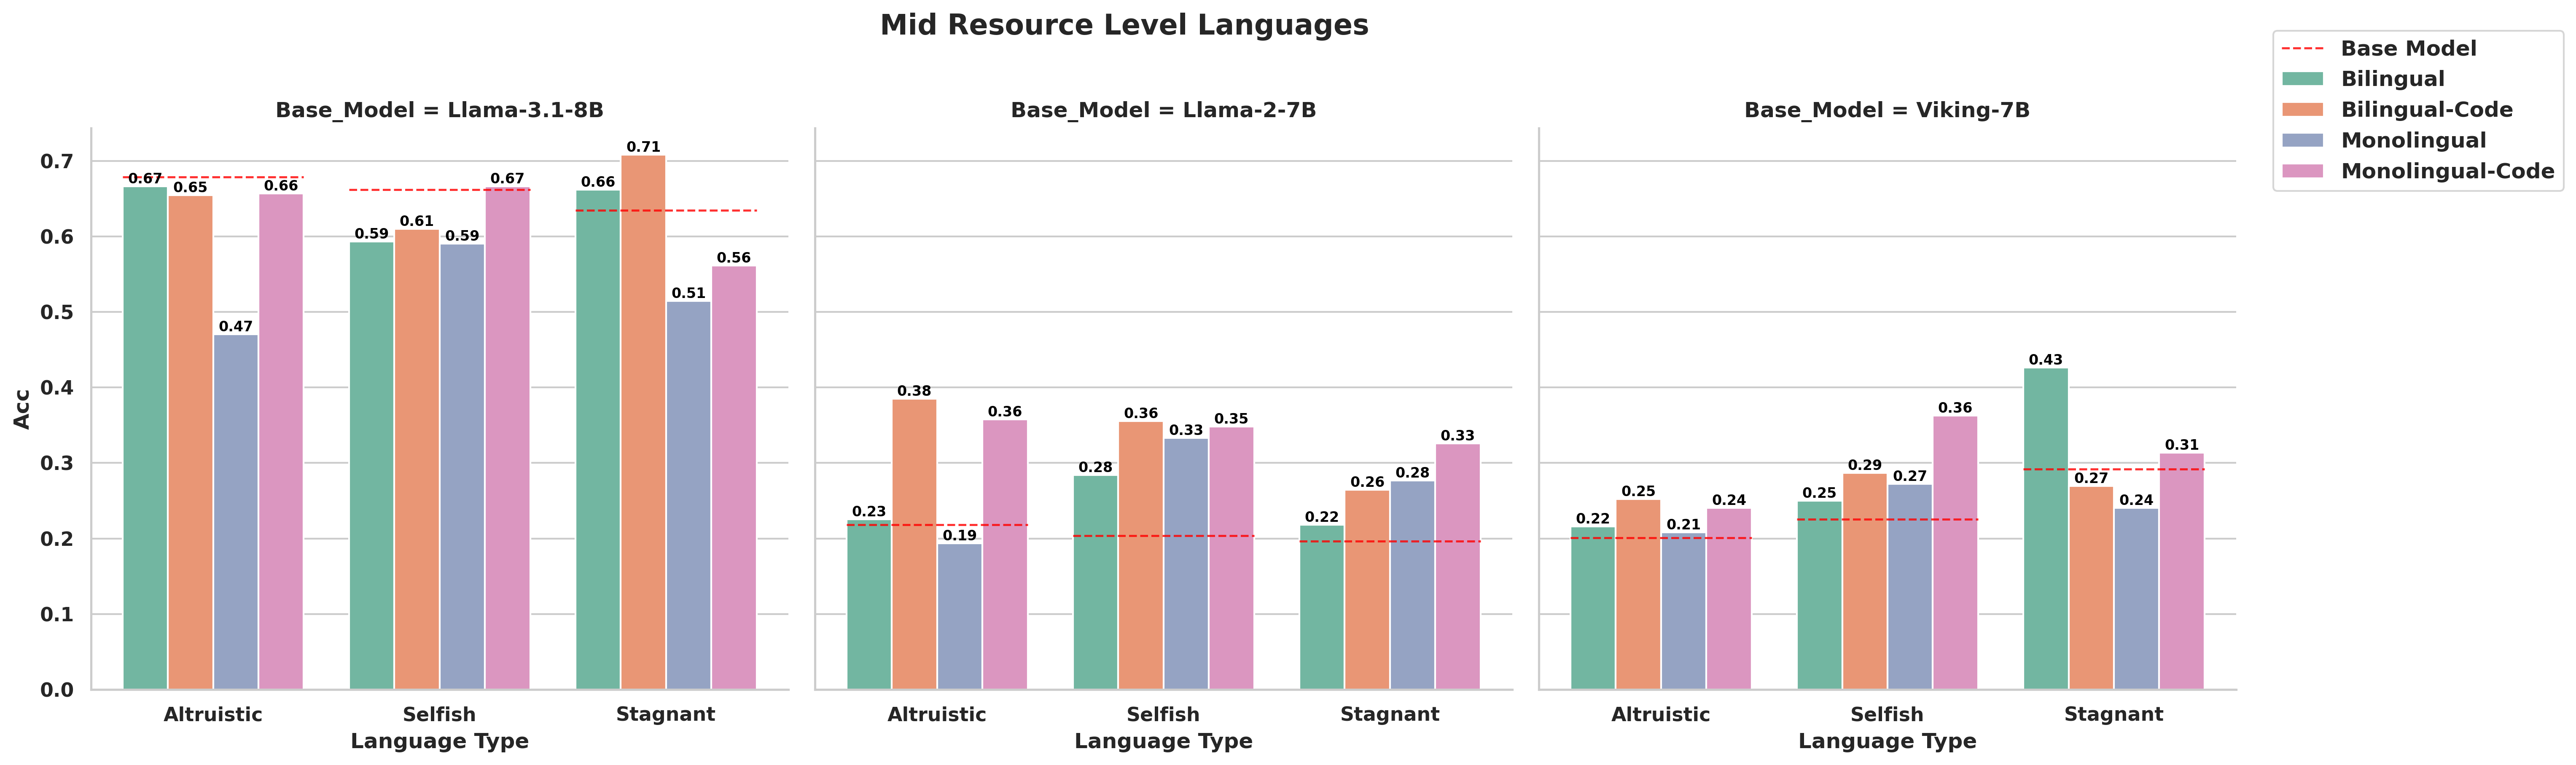

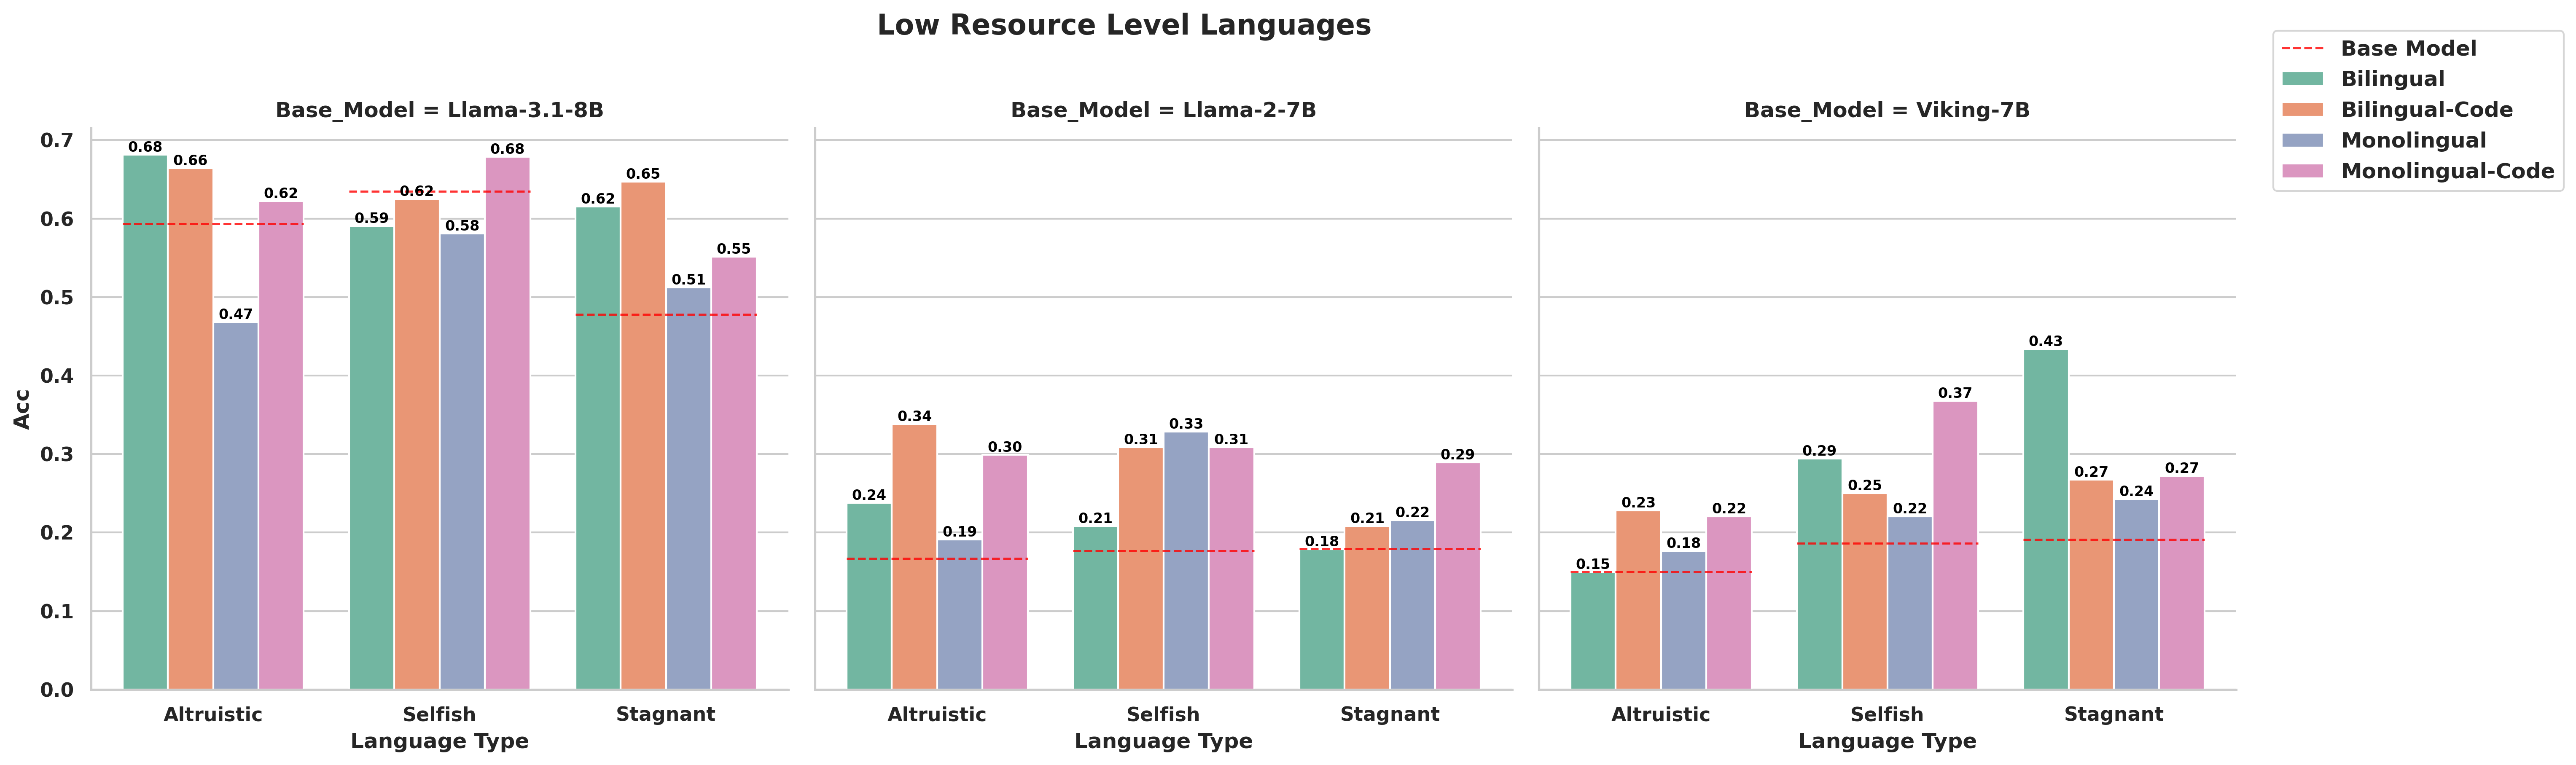

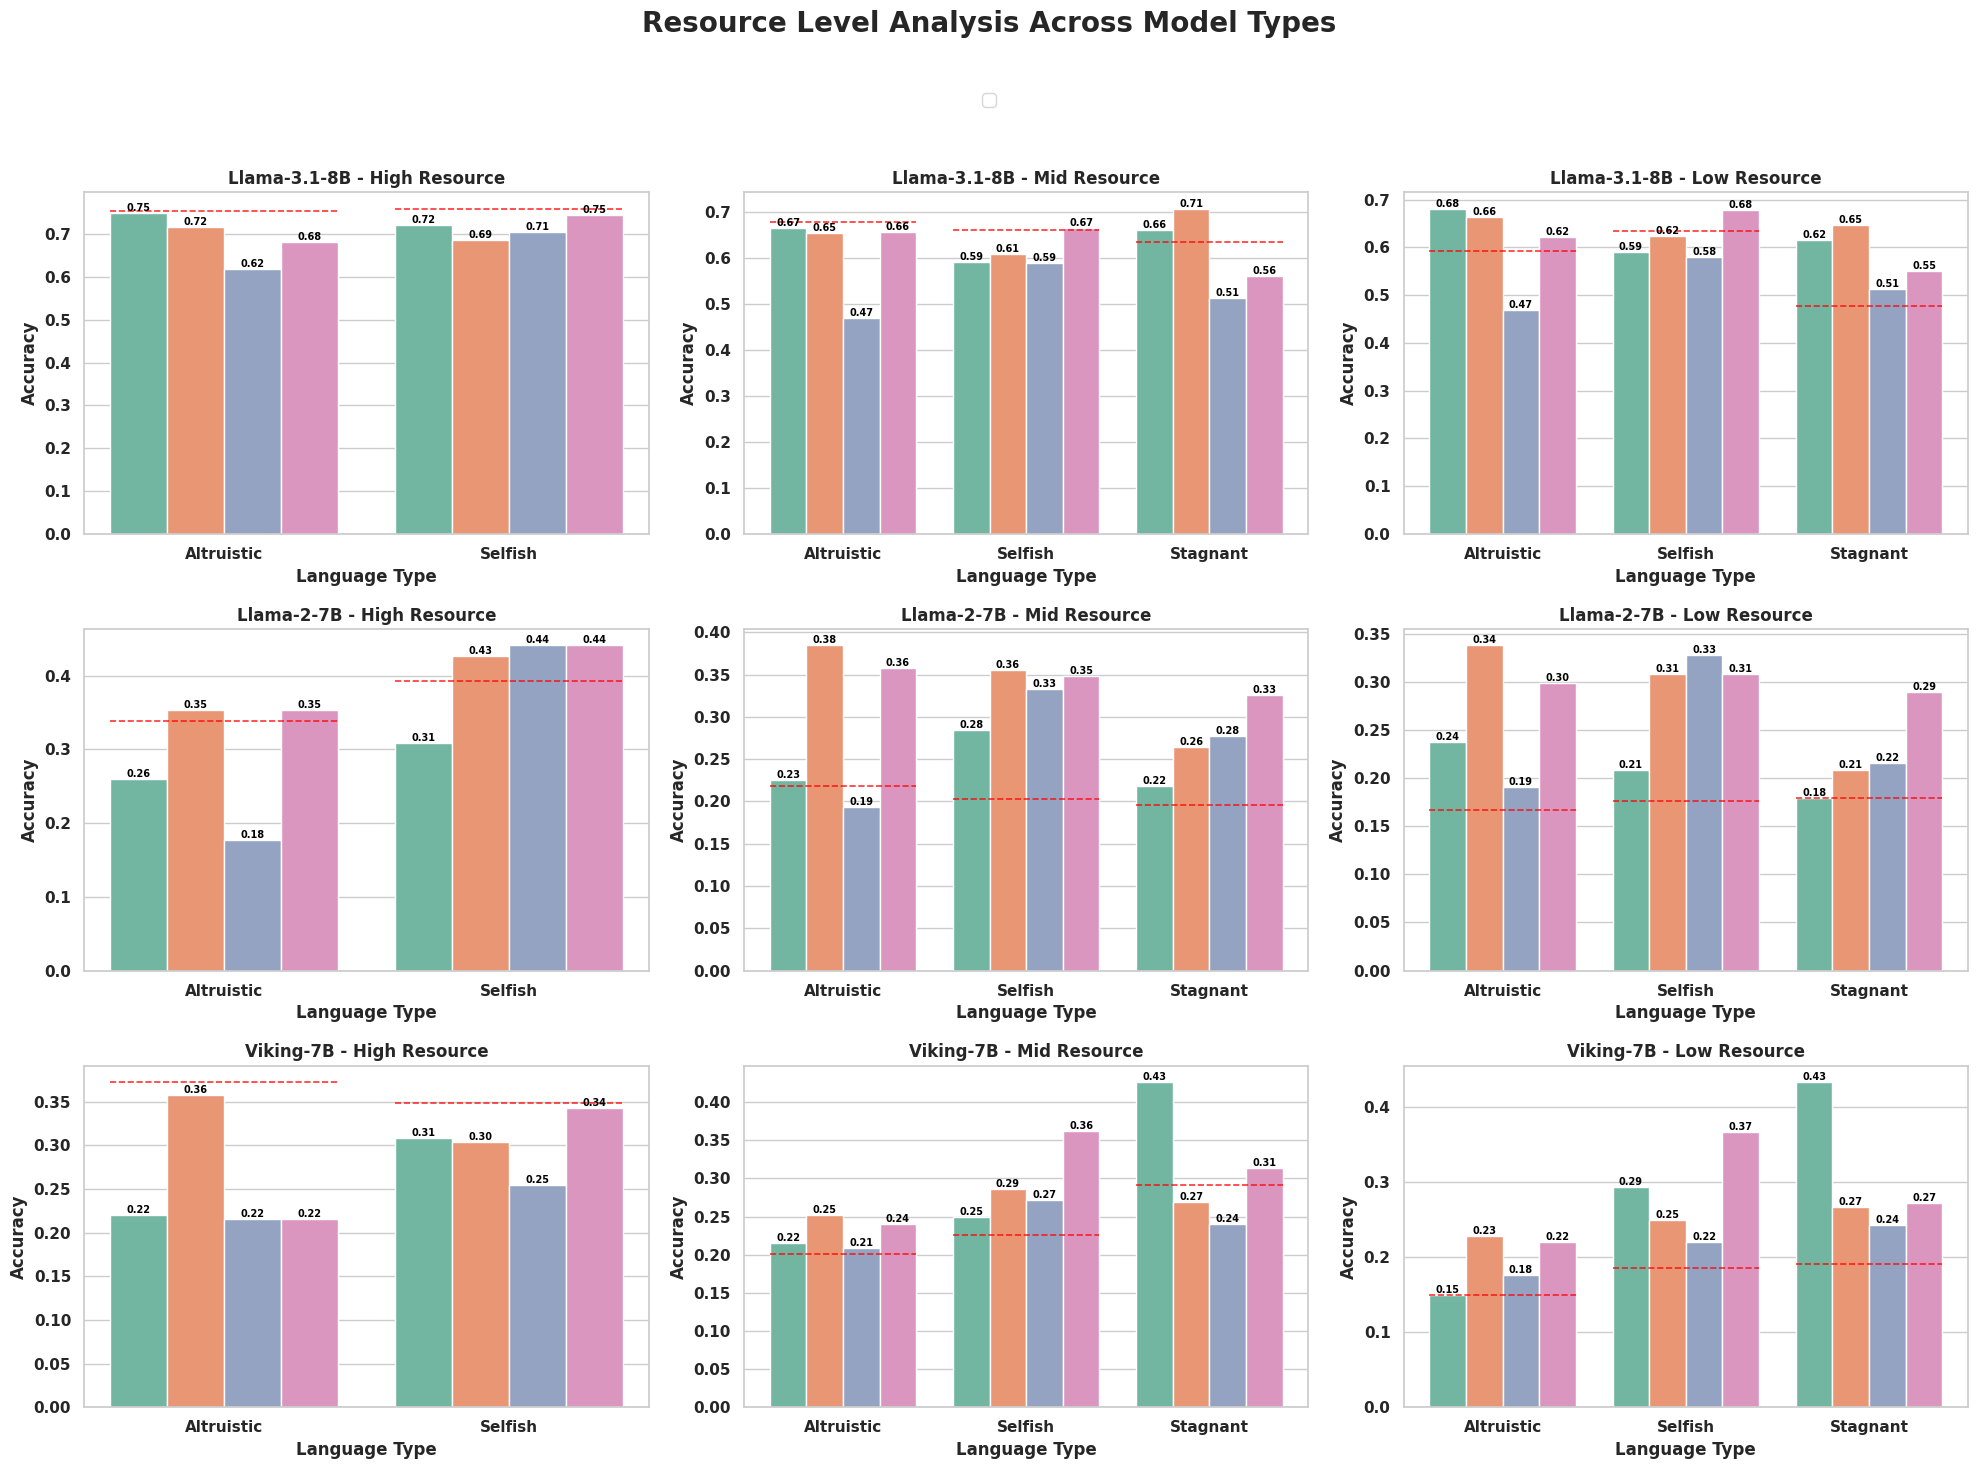

In [5]:
# Create separate plots for each resource level
for resource_level in ['High', 'Mid', 'Low']:
    # Filter data for the current resource level
    df_resource = df_agg[df_agg['Resource_Level'] == resource_level]
    
    # Skip if no data for this resource level (e.g., no High for Stagnant)
    if df_resource.empty:
        continue
    
    g = sns.catplot(
        data=df_resource,
        x="Language_Type",
        y="Score",
        hue="Data_Combination",
        col="Base_Model",
        kind="bar",
        palette="Set2",
        sharey=True,
        legend_out=False,
    )
    
    g.fig.set_size_inches(18, 6)
    g.fig.set_dpi(300)
    g.set_axis_labels("Language Type", "Acc")
    g.fig.suptitle(f"{resource_level} Resource Level Languages", y=1.01, fontsize=16, fontweight='bold')
    
    # Add base model reference lines
    for ax, model in zip(g.axes.flat, base_model_order):
        xtick_positions = ax.get_xticks()
        xtick_labels = [tick.get_text() for tick in ax.get_xticklabels()]
        
        for x, lang_type in zip(xtick_positions, xtick_labels):
            # Check if this combination exists in the base_lines dictionary
            if (model, resource_level, lang_type) in base_lines:
                val = base_lines[(model, resource_level, lang_type)]
                ax.hlines(
                    y=val,
                    xmin=x - 0.4,
                    xmax=x + 0.4,
                    color="red",
                    linestyles="--",
                    linewidth=1.2,
                    alpha=0.8,
                    label="Base Model",
                )
        
        # Add score labels on top of bars
        for bar in ax.patches:
            height = bar.get_height()
            if height > 0:
                ax.text(
                    bar.get_x() + bar.get_width() / 2,
                    height,
                    f'{height:.2f}',
                    ha='center',
                    va='bottom',
                    color='black',
                    fontweight='bold',
                    fontsize=8
                )
    
    # Create a unified legend
    all_handles, all_labels = [], []
    for ax in g.axes.flat:
        h, l = ax.get_legend_handles_labels()
        all_handles.extend(h)
        all_labels.extend(l)
    
    if g._legend:
        g._legend.remove()
    
    unique_handles, unique_labels = [], []
    for h, lbl in zip(all_handles, all_labels):
        if lbl not in unique_labels:
            unique_labels.append(lbl)
            unique_handles.append(h)
    
    g.fig.legend(unique_handles, unique_labels, loc="upper left", bbox_to_anchor=(1, 1))
    
    # Save figure
    g.savefig(f"SIB-200-{resource_level}-Resource.pdf", format="pdf", bbox_inches="tight")
    plt.tight_layout()
    plt.show()

# Create a comprehensive plot combining all data
fig, axes = plt.subplots(nrows=3, ncols=3, figsize=(20, 15), sharey=False)
fig.suptitle("Resource Level Analysis Across Model Types", fontsize=20, fontweight='bold', y=0.98)

# Resource levels to plot (note that not all combinations exist)
resource_levels = ['High', 'Mid', 'Low']

# Plot data for each base model and resource level combination
for row_idx, base_model in enumerate(base_model_order):
    for col_idx, resource_level in enumerate(resource_levels):
        ax = axes[row_idx, col_idx]
        
        # Filter data for current base model and resource level
        df_subplot = df_agg[(df_agg['Base_Model'] == base_model) & (df_agg['Resource_Level'] == resource_level)]
        
        # Skip if no data for this combination
        if df_subplot.empty:
            ax.text(0.5, 0.5, f"No data for {base_model}\nwith {resource_level} resources", 
                    ha='center', va='center', fontsize=12, fontweight='bold')
            ax.set_xticks([])
            ax.set_yticks([])
            continue
            
        # Create the bar plot
        sns.barplot(
            data=df_subplot,
            x="Language_Type",
            y="Score",
            hue="Data_Combination",
            palette="Set2",
            ax=ax
        )
        
        # Add base model reference lines
        xtick_positions = ax.get_xticks()
        xtick_labels = [tick.get_text() for tick in ax.get_xticklabels()]
        
        for x, lang_type in zip(xtick_positions, xtick_labels):
            # Check if this combination exists in the base_lines dictionary
            if (base_model, resource_level, lang_type) in base_lines:
                val = base_lines[(base_model, resource_level, lang_type)]
                ax.hlines(
                    y=val,
                    xmin=x - 0.4,
                    xmax=x + 0.4,
                    color="red",
                    linestyles="--",
                    linewidth=1.2,
                    alpha=0.8,
                    label="Base Model",
                )
        
        # Add score labels
        for bar in ax.patches:
            height = bar.get_height()
            if height > 0:
                ax.text(
                    bar.get_x() + bar.get_width() / 2,
                    height,
                    f'{height:.2f}',
                    ha='center',
                    va='bottom',
                    color='black',
                    fontweight='bold',
                    fontsize=7
                )
        
        # Set subplot title and labels
        ax.set_title(f"{base_model} - {resource_level} Resource", fontweight='bold')
        ax.set_xlabel("Language Type")
        ax.set_ylabel("Accuracy")
        
        # Remove legend from individual subplots
        if ax.get_legend():
            ax.get_legend().remove()

# Create a unified legend for the combined plot
handles, labels = [], []
for ax in axes.flatten():
    if hasattr(ax, 'legend_') and ax.legend_ is not None:
        h, l = ax.get_legend_handles_labels()
        handles.extend(h)
        labels.extend(l)

unique_handles, unique_labels = [], []
for h, lbl in zip(handles, labels):
    if lbl not in unique_labels:
        unique_labels.append(lbl)
        unique_handles.append(h)

fig.legend(unique_handles, unique_labels, loc="upper center", bbox_to_anchor=(0.5, 0.93), ncol=5)

# Adjust layout and save
plt.tight_layout(rect=[0, 0, 1, 0.92])
plt.savefig("SIB-200-Comprehensive.pdf", format="pdf", bbox_inches="tight")
plt.show()